In [1]:
import pandas as pd
import numpy as np
import joblib

In [3]:
df = pd.read_csv('test_set_MLP.csv')
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,0.881159,0.950190,0.158387,3.252233,-0.952010,-0.256106,-0.415677,-1.537221,-1.256502,0.518296,...,3.110695,1.047736,-0.459731,-0.076720,1.723295,-0.91731,0.496401,-0.890490,-0.782495,1.0
1,0.881159,0.950190,0.158387,0.161114,1.050409,-0.256106,2.405711,0.650525,0.795860,0.518296,...,-0.321472,0.149098,-0.459731,-0.575632,1.723295,-0.91731,1.197751,-0.890490,-0.782495,0.0
2,0.881159,0.950190,0.158387,-1.665456,1.050409,-0.256106,-0.415677,-1.537221,0.795860,0.518296,...,-0.321472,0.149098,-0.459731,-0.575632,-0.580284,-0.91731,1.548426,-0.890490,-1.702427,1.0
3,-1.134869,-1.052422,0.158387,-1.243939,1.050409,-0.256106,-0.415677,0.650525,0.795860,0.518296,...,-0.321472,-1.648179,-0.459731,-0.575632,-0.580284,-0.91731,-0.555625,1.051358,1.057370,0.0
4,0.881159,0.950190,0.158387,1.144652,-0.952010,-0.256106,-0.415677,0.650525,-1.256502,-1.929401,...,-0.321472,0.149098,-0.459731,-0.376067,-0.580284,-0.91731,-0.555625,-0.890490,1.057370,1.0


In [5]:
X_test = df.drop(columns='Diabetes_binary').values.astype(np.float32)
y_test = df['Diabetes_binary'].values.astype(np.int64)

In [15]:
import torch.nn as nn
from torch.serialization import add_safe_globals
from torch.nn.modules.linear import Linear
from torch.nn.modules.batchnorm import BatchNorm1d
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.loss import BCELoss
from torch.nn.functional import relu
from torch import sigmoid
from torch.nn import Module
from torch.optim import SGD, Adam
from collections import defaultdict

# Define the MLP model with optimal hyper-parameters
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim = 30):   # 30 hidden neurons are implemented
        super(MLPModule, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)   # Input layer --> Hidden layer
        self.output = nn.Linear(hidden_dim, 1)           # Hidden layer --> Output layer

    def forward(self, X):
        X = F.relu(self.hidden(X))   # ReLU activation function is applied to the output of the hidden layer
        X = torch.sigmoid(self.output(X))   # Sigmoid function is applied to the output of the output layer
        return X.view(-1)   # Reshaping output tensor as the BCELoss function expects a 1D vector

add_safe_globals([
    MLPModule, Linear, BatchNorm1d, Dropout, BCELoss,
    relu, sigmoid, Module, SGD, Adam,
    defaultdict, dict  # added built-in dict
])

best_MLP = joblib.load('best_MLP.pkl')

In [21]:
import torch
import torch.nn.functional as F
y_pred = best_MLP.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.7520
Precision: 0.7300
Recall   : 0.8000
F1 Score : 0.7634


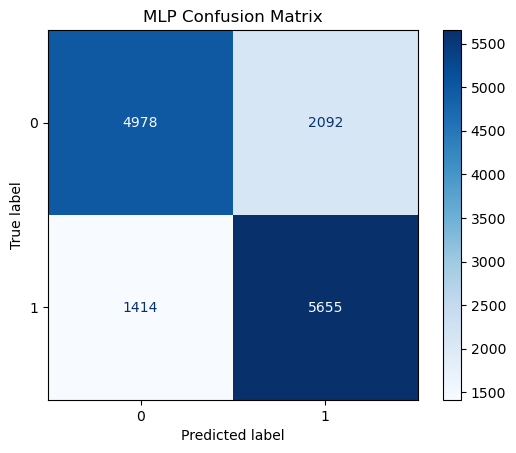

In [27]:
# Importing functions to plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plotting confusion matrix on true vs predicted values
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()

/var/folders/k7/3ph50_zd6wn9fdg37q55y20r0000gn/T/ipykernel_1787/3515549415.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line


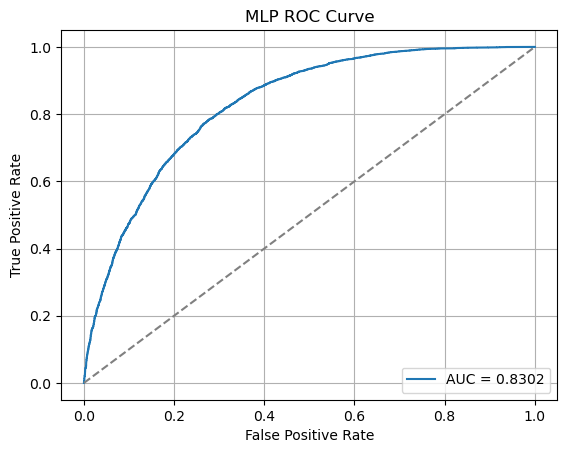

In [33]:
# Importing functions to plot and evaluate the area under the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

# Getting probabilities for class 1
y_proba = best_MLP.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plotting the curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()